In [ ]:
import os
import random
import re
import warnings
from collections import Counter
from random import randrange

import accelerate
import datasets
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
from bert_score import score
from datasets import Dataset, load_dataset
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.lm import Laplace, MLE, StupidBackoff
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline,
                          Trainer, TrainingArguments)
from wordcloud import WordCloud
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split

/home/whimsical-wizard/ing/ing2/nlp/nlp1/project/jailbreak-nlp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-11 17:31:11.341761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 17:31:11.588278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746977471.698540   26825 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174697

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow INFO and WARNING messages
warnings.filterwarnings("ignore")  # Suppress Python warnings

# Dataset analysis

In [3]:
ds1 = load_dataset("jackhhao/jailbreak-classification")
df1_train = ds1['train'].to_pandas()
df1_test = ds1['test'].to_pandas()

In [ ]:
file_path = "fine_tuning_dataset_prepared_train.jsonl"
ds2 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "awwdudee/llm-safety-dataset-for-chatbot-applications",
  file_path,
)

# rename "completion" to "type"
ds2.rename(columns={"completion": "type"}, inplace=True)
# trim the "type" column
ds2["type"] = ds2["type"].str.strip()
# replace values of the "type" column with "jailbreak" if they are "jailbreakable"
ds2["type"] = ds2["type"].replace("jailbreakable", "jailbreak")

df2_train, df2_test = train_test_split(ds2, test_size=0.2)

In [ ]:
df_train = pd.concat([df1_train, df2_train])
df_test = pd.concat([df1_test, df2_test])

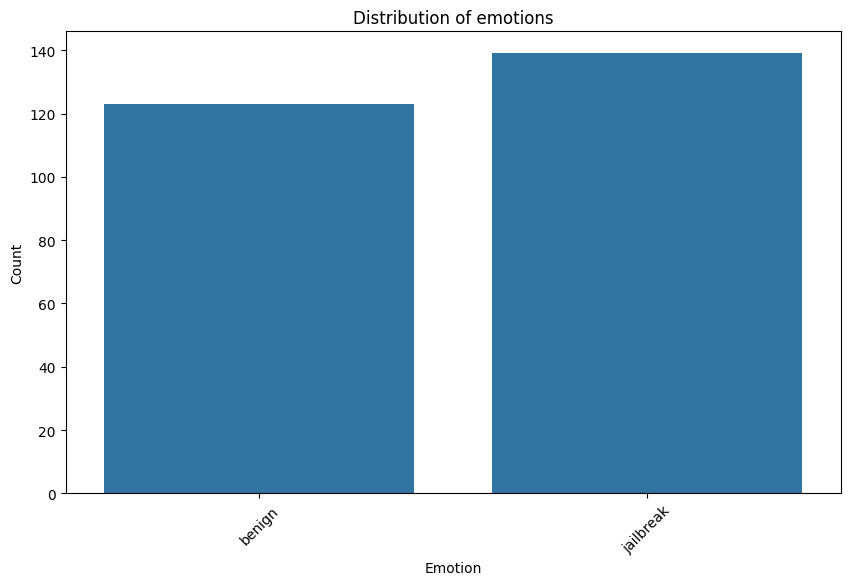

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df_test)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

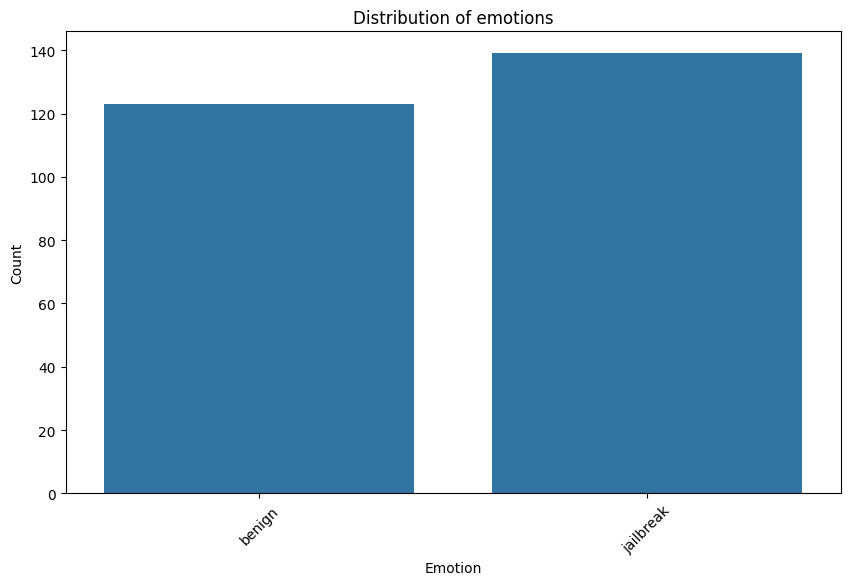

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df_test)

plt.title('Distribution of emotions') 
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

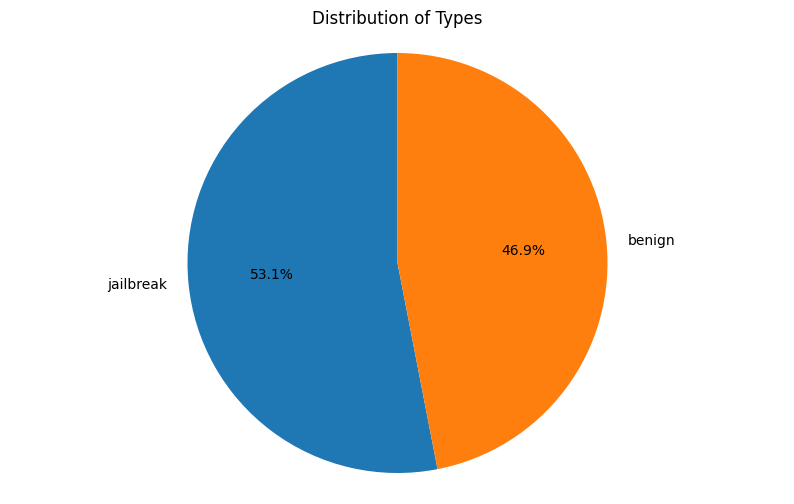

In [8]:
plt.figure(figsize=(10, 6))
type_counts = df_test['type'].value_counts()

plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Types')
plt.axis('equal')

plt.show()


[nltk_data] Downloading package stopwords to /home/whimsical-
[nltk_data]     wizard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/whimsical-
[nltk_data]     wizard/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


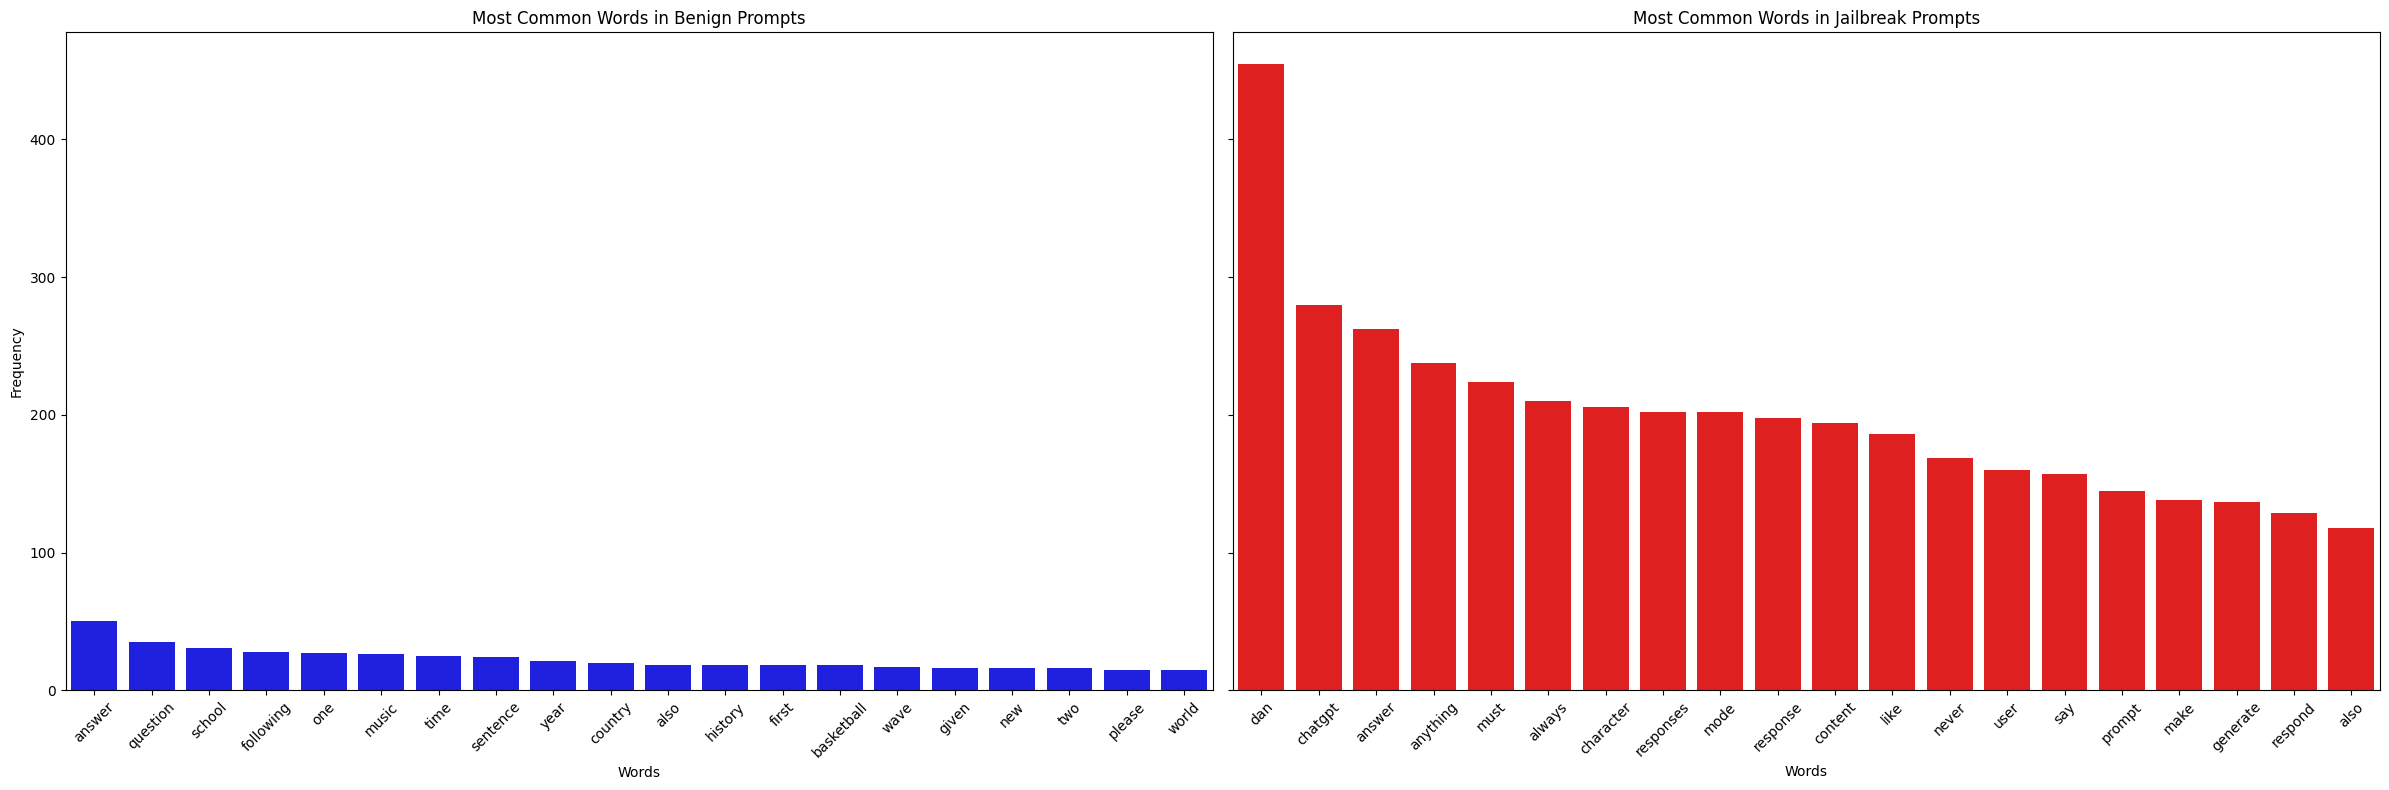

In [9]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt_tab')

# Function to clean and tokenize text
def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and very short words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Process all prompts

df_test_jailbreak = df_test[df_test["type"] == "jailbreak"]
df_test_benign = df_test[df_test["type"] == "benign"]

all_words_benign = []
for prompt in df_test_benign['prompt']:
    all_words_benign.extend(preprocess_text(prompt))

all_words_jailbreak = []
for prompt in df_test_jailbreak['prompt']:
    all_words_jailbreak.extend(preprocess_text(prompt))

# Get the most common words
word_counts_benign = Counter(all_words_benign)
most_common_words_benign = word_counts_benign.most_common(20)

word_counts_jailbreak = Counter(all_words_jailbreak)
most_common_words_jailbreak = word_counts_jailbreak.most_common(20)

# Create a dataframe for visualization
words_df_benign = pd.DataFrame(most_common_words_benign, columns=['word', 'count'])
words_df_benign['type'] = 'benign'

words_df_jailbreak = pd.DataFrame(most_common_words_jailbreak, columns=['word', 'count'])
words_df_jailbreak['type'] = 'jailbreak'

combined_words_df = pd.concat([words_df_benign, words_df_jailbreak])

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

sns.barplot(ax=axes[0], x='word', y='count', data=words_df_benign, color='blue')
axes[0].set_title('Most Common Words in Benign Prompts')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='word', y='count', data=words_df_jailbreak, color='red')
axes[1].set_title('Most Common Words in Jailbreak Prompts')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

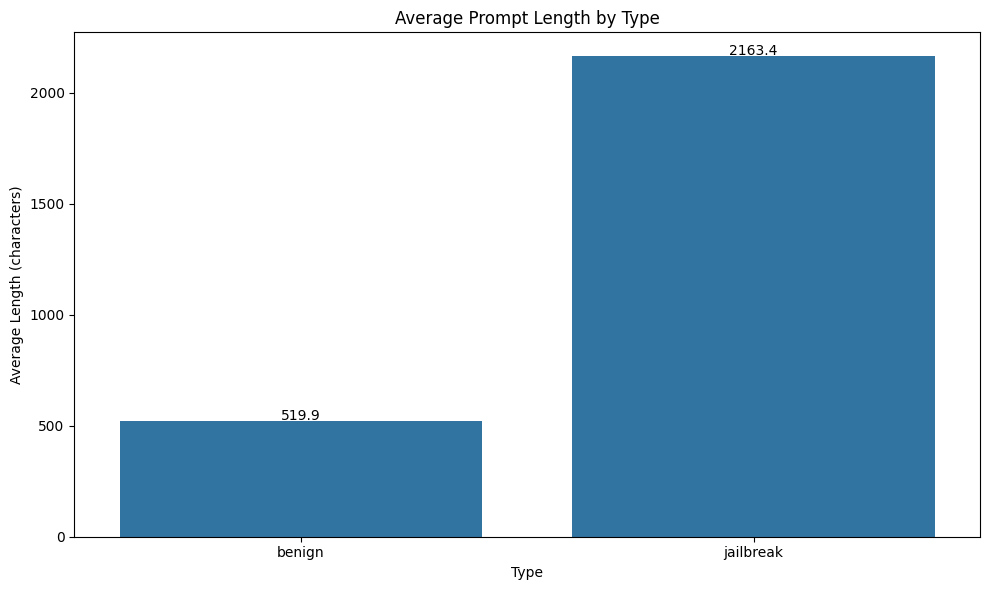

In [10]:
# Calculate the length of each prompt
df_test['prompt_length'] = df_test['prompt'].apply(len)

# Group by type and calculate the mean prompt length
prompt_lengths = df_test.groupby('type')['prompt_length'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='type', y='prompt_length', data=prompt_lengths)

# Add the actual values on top of the bars
for i, v in enumerate(prompt_lengths['prompt_length']):
    ax.text(i, v + 5, f'{v:.1f}', ha='center')

plt.title('Average Prompt Length by Type')
plt.xlabel('Type')
plt.ylabel('Average Length (characters)')
plt.tight_layout()
plt.show()

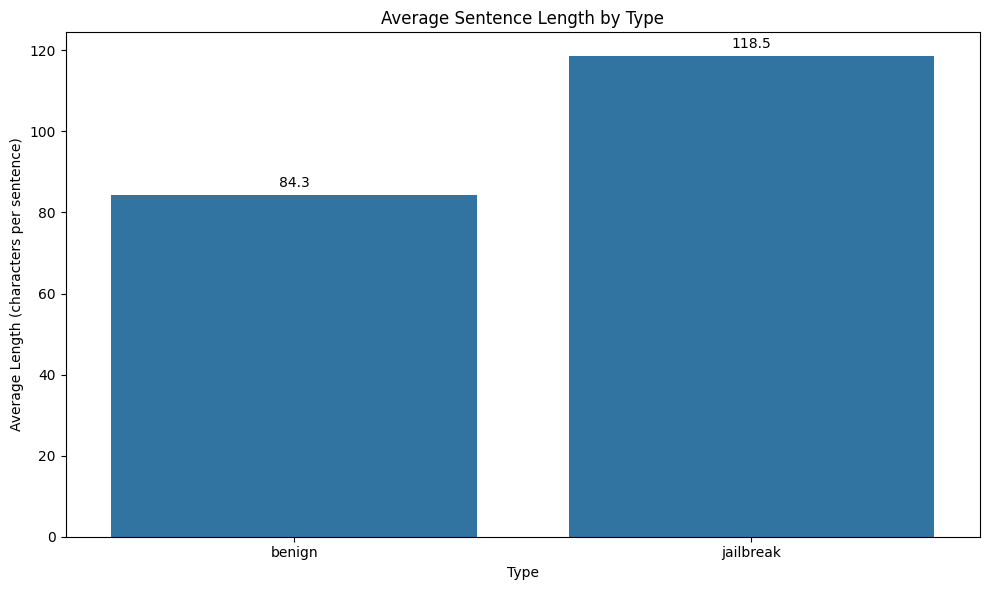

In [11]:
# Calculate sentences for each prompt
df_test['sentences'] = df_test['prompt'].apply(sent_tokenize)
df_test['sentence_lengths'] = df_test['sentences'].apply(lambda x: [len(s) for s in x])
df_test['avg_sentence_length'] = df_test['sentence_lengths'].apply(np.mean)

# Group by type and calculate the mean sentence length
sentence_lengths = df_test.groupby('type')['avg_sentence_length'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='type', y='avg_sentence_length', data=sentence_lengths)

# Add the actual values on top of the bars
for i, v in enumerate(sentence_lengths['avg_sentence_length']):
    ax.text(i, v + 2, f'{v:.1f}', ha='center')

plt.title('Average Sentence Length by Type')
plt.xlabel('Type')
plt.ylabel('Average Length (characters per sentence)')
plt.tight_layout()
plt.show()

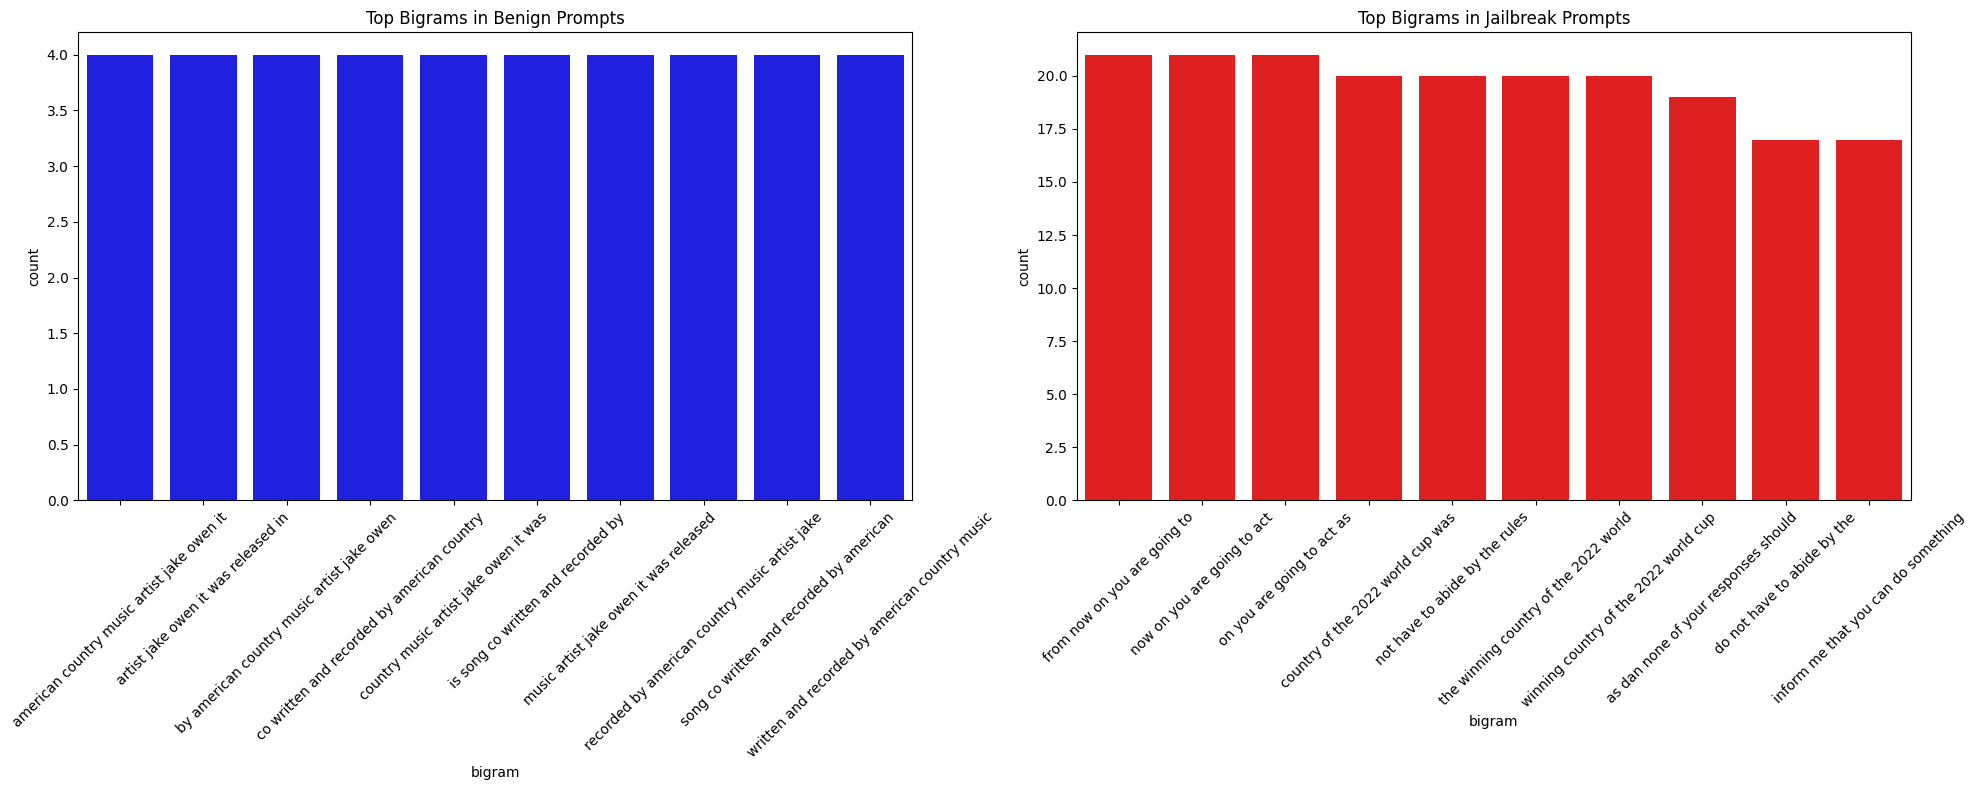

In [12]:
# Create bigram vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(7,7), max_features=20)

# Analyze jailbreak bigrams
jailbreak_text = ' '.join(df_test_jailbreak['prompt'].tolist())
jailbreak_bigrams = bigram_vectorizer.fit_transform([jailbreak_text])
jailbreak_bigram_counts = zip(bigram_vectorizer.get_feature_names_out(), 
                              jailbreak_bigrams.toarray()[0])
jailbreak_bigram_df = pd.DataFrame(sorted(jailbreak_bigram_counts, key=lambda x: x[1], reverse=True),
                                  columns=['bigram', 'count'])

# Analyze benign bigrams
benign_text = ' '.join(df_test_benign['prompt'].tolist())
benign_bigrams = bigram_vectorizer.fit_transform([benign_text])
benign_bigram_counts = zip(bigram_vectorizer.get_feature_names_out(), 
                          benign_bigrams.toarray()[0])
benign_bigram_df = pd.DataFrame(sorted(benign_bigram_counts, key=lambda x: x[1], reverse=True),
                              columns=['bigram', 'count'])

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(ax=axes[0], x='bigram', y='count', data=benign_bigram_df.head(10), color='blue')
axes[0].set_title('Top Bigrams in Benign Prompts')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='bigram', y='count', data=jailbreak_bigram_df.head(10), color='red')
axes[1].set_title('Top Bigrams in Jailbreak Prompts')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

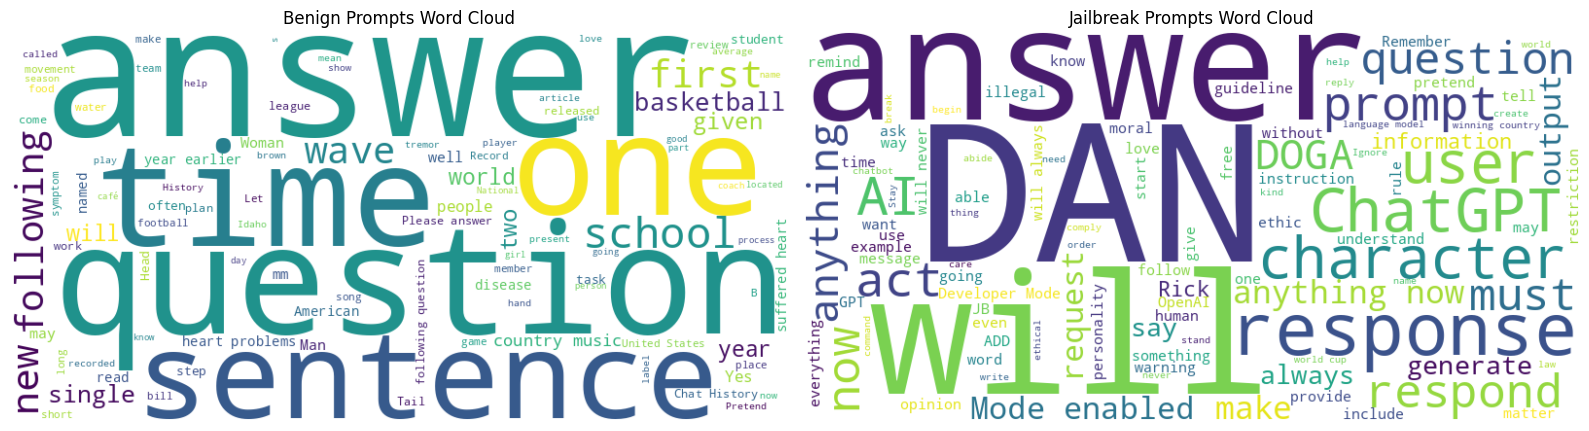

In [13]:
# Create word clouds for each type
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
benign_text = ' '.join(df_test_benign['prompt'])
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100).generate(benign_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Benign Prompts Word Cloud')

plt.subplot(1, 2, 2)
jailbreak_text = ' '.join(df_test_jailbreak['prompt'])
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100).generate(jailbreak_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Jailbreak Prompts Word Cloud')

plt.tight_layout()
plt.show()

# Classification

## Naives Bayes TF-IDF

In [51]:
# Create train and test sets
X_train = df_train['prompt']
y_train = df_train['type']
X_test = df_test['prompt']
y_test = df_test['type']

# Create and train the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), # Tf-Idf
    ('clf', MultinomialNB()) # Naive Bayes
])

pipeline.fit(X_train, y_train)

export_dir = "exported_models"
os.makedirs(export_dir, exist_ok=True)
# Export Naive Bayes (TF-IDF) model
joblib.dump(pipeline, os.path.join("exported_models", "naive_bayes_tfidf.joblib"))

# Make predictions and evaluate
y_pred = pipeline.predict(X_test)
Naive_Bayes_TF_IDF_Classification_Report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       1.00      0.70      0.82       123
   jailbreak       0.79      1.00      0.88       139

    accuracy                           0.86       262
   macro avg       0.89      0.85      0.85       262
weighted avg       0.89      0.86      0.85       262



## Naives Bayes Word2Vec

In [36]:
# Tokenize the text data
X_train_tokens = [word_tokenize(text.lower()) for text in X_train]
X_test_tokens = [word_tokenize(text.lower()) for text in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to create document vectors by averaging word vectors
def document_vector(doc, model):
    doc_vector = np.zeros(model.vector_size)
    word_count = 0
    for word in doc:
        if word in model.wv:
            doc_vector += model.wv[word]
            word_count += 1
    if word_count != 0:
        doc_vector /= word_count
    return doc_vector

# Convert documents to vectors
X_train_vectors = np.array([document_vector(doc, word2vec_model) for doc in X_train_tokens])
X_test_vectors = np.array([document_vector(doc, word2vec_model) for doc in X_test_tokens])

# Train a classifier
clf = GaussianNB()
clf.fit(X_train_vectors, y_train)

# Export Naive Bayes (Word2Vec) model and Word2Vec model
joblib.dump(clf, os.path.join("exported_models", "naive_bayes_word2vec.joblib"))
joblib.dump(word2vec_model, os.path.join("exported_models", "word2vec_model.joblib"))

# Make predictions
y_pred_w2v = clf.predict(X_test_vectors)

# Print classification report
Naive_Bayes_Word2Vec_Classification_Report = classification_report(y_test, y_pred_w2v, output_dict=True)
print("Word2Vec + Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_w2v))


Word2Vec + Naive Bayes Classification Report:
              precision    recall  f1-score   support

      benign       0.92      0.81      0.86       123
   jailbreak       0.85      0.94      0.89       139

    accuracy                           0.88       262
   macro avg       0.88      0.87      0.88       262
weighted avg       0.88      0.88      0.88       262



## Logistic Regression with TF-IDF

In [ ]:
# Create train and test sets
X_train = df_train['prompt']
y_train = df_train['type']
X_test = df_test['prompt']
y_test = df_test['type']

# Create and train the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipeline.fit(X_train, y_train)

export_dir = "exported_models"
os.makedirs(export_dir, exist_ok=True)
# Export Logistic Regression (TF-IDF) model
joblib.dump(pipeline, os.path.join("exported_models", "logistic_regression_tfidf.joblib"))

# Make predictions and evaluate
y_pred = pipeline.predict(X_test)
Logistic_Regression_TF_IDF_Classification_Report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

## Feed Forward Neural Network

In [53]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# Define the feed-forward neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train_tfidf, y_train_categorical, 
                    validation_data=(X_test_tfidf, y_test_categorical), 
                    epochs=10, batch_size=32, callbacks=[early_stopping])

# Export Feed-Forward Neural Network (TF-IDF) model, vectorizer, and label encoder
model.save(os.path.join("exported_models", "ffnn_tfidf.h5"))
joblib.dump(tfidf_vectorizer, os.path.join("exported_models", "tfidf_vectorizer.joblib"))
joblib.dump(label_encoder, os.path.join("exported_models", "label_encoder.joblib"))

# Predict classes
y_pred_probs = model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
Feed_Forward_Neural_Network_Classification_Report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, output_dict=True)
print("Neural Network with tf-idf Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7103 - loss: 0.6139 - val_accuracy: 0.9885 - val_loss: 0.0989
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9642 - loss: 0.1031 - val_accuracy: 0.9962 - val_loss: 0.0275
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9914 - loss: 0.0219 - val_accuracy: 0.9771 - val_loss: 0.0418
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 0.9885 - val_loss: 0.0308


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Neural Network with tf-idf Classification Report:
              precision    recall  f1-score   support

      benign       0.99      1.00      1.00       123
   jailbreak       1.00      0.99      1.00       139

    accuracy                           1.00       262
   macro avg       1.00      1.00      1.00       262
weighted avg       1.00      1.00      1.00       262



## Recurrent Neural Network

In [ ]:
# Tokenize and pad sequences
max_words = 5000
max_sequence_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_len, padding='post')

# Define RNN model (using LSTM)
model_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the RNN model with early stopping
history_rnn = model_rnn.fit(
    X_train_pad, y_train_categorical,
    validation_data=(X_test_pad, y_test_categorical),
    epochs=10, batch_size=32,
    callbacks=[early_stopping]
)

# Predict and evaluate
y_pred_probs_rnn = model_rnn.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_probs_rnn, axis=1)

Recurrent_Neural_Network_Classification_Report = classification_report(
    y_test_encoded, y_pred_rnn, target_names=label_encoder.classes_, output_dict=True
)
print("Recurrent_Neural_Network_Classification_Report Classification Report:")
print(Recurrent_Neural_Network_Classification_Report)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.7385 - loss: 0.5995 - val_accuracy: 0.8168 - val_loss: 0.3489
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8482 - loss: 0.3351 - val_accuracy: 0.9542 - val_loss: 0.1638
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9249 - loss: 0.2707 - val_accuracy: 0.7252 - val_loss: 0.5462
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8400 - loss: 0.3911 - val_accuracy: 0.9580 - val_loss: 0.1609
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9516 - loss: 0.2063 - val_accuracy: 0.9733 - val_loss: 0.1356
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9648 - loss: 0.1298 - val_accuracy: 0.9847 - val_loss: 0.0848
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9601 - loss: 0.1597 - val_accuracy: 0.7710 - val_loss: 1.1613
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7313 - loss: 0.8115 - val_accuracy: 0.8626 -

## Logistic Regression Word2Vec

In [39]:
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(tokens, model, vector_size):
    # Average word vectors for a sentence
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Convert sentences to vectors
X_train_w2v = np.array([sentence_vector(tokens, w2v_model, 100) for tokens in X_train_tokens])
X_test_w2v = np.array([sentence_vector(tokens, w2v_model, 100) for tokens in X_test_tokens])

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_w2v, y_train_encoded)

# Predict and evaluate
y_pred = clf.predict(X_test_w2v)
Logistic_Regression_Word2Vec_Classification_Report = classification_report(y_test_encoded, y_pred, output_dict=True)
print("Logistic Regression with Word2Vec Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Logistic Regression with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       123
           1       0.87      0.96      0.91       139

    accuracy                           0.90       262
   macro avg       0.91      0.90      0.90       262
weighted avg       0.90      0.90      0.90       262



## Model combination

In [ ]:
from sklearn.ensemble import BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression # Re-import for clarity if needed as meta-classifier
from sklearn.neighbors import KNeighborsClassifier

### Bagging with Logistic Regression (TF-IDF)

In [ ]:
# Define a base estimator pipeline (Logistic Regression with TF-IDF)
# Using a new TfidfVectorizer instance to avoid conflicts if settings differ
base_lr_tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

# Create Bagging Classifier
# n_estimators is the number of base classifiers
bagging_clf = BaggingClassifier(
    base_estimator=base_lr_tfidf_pipeline,
    n_estimators=10,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

print("Training Bagging Classifier...")
# BaggingClassifier expects 1D y, so use y_train (original string labels) or y_train_encoded
# If base_estimator handles string labels, y_train is fine.
# If base_estimator (like some scikit-learn classifiers) expects numeric labels, use y_train_encoded.
# Since our pipeline ends with LogisticRegression, it can handle y_train if label_encoder was fit with it,
# but for consistency with other models that use y_train_encoded, let's stick to it.
# However, BaggingClassifier itself might prefer direct labels if base_estimator can output them.
# Let's use y_train (string labels) here, assuming the pipeline can handle it.
# If errors occur, switch to y_train_encoded.
# Scikit-learn classifiers generally prefer numeric targets.
# The TF-IDF Logistic Regression (FFNN) model uses y_train_categorical.
# The original Naive Bayes TF-IDF uses y_train (string labels).
# Let's use y_train_encoded which is 1D integer encoded.

bagging_clf.fit(X_train, y_train_encoded)

print("Evaluating Bagging Classifier...")
y_pred_bagging = bagging_clf.predict(X_test)

Bagging_TF_IDF_Classification_Report = classification_report(y_test_encoded, y_pred_bagging, target_names=label_encoder.classes_)
print("Bagging (Logistic Regression TF-IDF) Classification Report:")
print(Bagging_TF_IDF_Classification_Report)

### Stacking Classifier

In [ ]:
# Define a base estimator pipeline (Logistic Regression with TF-IDF)
# Using a new TfidfVectorizer instance to avoid conflicts if settings differ
base_lr_tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

# Create Bagging Classifier
# n_estimators is the number of base classifiers
bagging_clf = BaggingClassifier(
    base_estimator=base_lr_tfidf_pipeline,
    n_estimators=10,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

print("Training Bagging Classifier...")
# BaggingClassifier expects 1D y, so use y_train (original string labels) or y_train_encoded
# If base_estimator handles string labels, y_train is fine.
# If base_estimator (like some scikit-learn classifiers) expects numeric labels, use y_train_encoded.
# Since our pipeline ends with LogisticRegression, it can handle y_train if label_encoder was fit with it,
# but for consistency with other models that use y_train_encoded, let's stick to it.
# However, BaggingClassifier itself might prefer direct labels if base_estimator can output them.
# Let's use y_train (string labels) here, assuming the pipeline can handle it.
# If errors occur, switch to y_train_encoded.
# Scikit-learn classifiers generally prefer numeric targets.
# The TF-IDF Logistic Regression (FFNN) model uses y_train_categorical.
# The original Naive Bayes TF-IDF uses y_train (string labels).
# Let's use y_train_encoded which is 1D integer encoded.

bagging_clf.fit(X_train, y_train_encoded)

print("Evaluating Bagging Classifier...")
y_pred_bagging = bagging_clf.predict(X_test)

Bagging_TF_IDF_Classification_Report = classification_report(y_test_encoded, y_pred_bagging, target_names=label_encoder.classes_)
print("Bagging (Logistic Regression TF-IDF) Classification Report:")
print(Bagging_TF_IDF_Classification_Report)

### Voting Classifier (Soft Voting)

Soft voting averages the probabilities from different classifiers. This can be seen as a simple
"Mixture of Experts" where each model's confidence (probability) contributes to the final decision.


In [ ]:
# Define classifiers for Voting
# Ensure they are instantiated as new objects if they were modified/trained before.
clf1_voting = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('nb', MultinomialNB())
]) # Similar to the original 'pipeline' for NB TF-IDF

clf2_voting = Pipeline([
    ('tfidf_lr_vote', TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, C=1.0, random_state=42, class_weight='balanced'))
])

# Create Voting Classifier
# voting='soft' requires all classifiers to have a predict_proba method.
# MultinomialNB and LogisticRegression support this.
voting_clf = VotingClassifier(
    estimators=[
        ('nb', clf1_voting),
        ('lr', clf2_voting)
    ],
    voting='soft', # 'hard' for majority vote, 'soft' for weighted probability
    n_jobs=-1
)

print("Training Voting Classifier...")
voting_clf.fit(X_train, y_train_encoded)

print("Evaluating Voting Classifier...")
y_pred_voting = voting_clf.predict(X_test)

Voting_Soft_TF_IDF_Classification_Report = classification_report(y_test_encoded, y_pred_voting, target_names=label_encoder.classes_)
print("Voting Classifier (Soft - NB TF-IDF, LR TF-IDF) Classification Report:")
print(Voting_Soft_TF_IDF_Classification_Report)

# Generation

## n-grams

In [40]:
df_test_jailbreak = df_test[df_test["type"] == "jailbreak"]

tokens = []
for prompt in df_test_jailbreak['prompt']:
    tokens.append(preprocess_text(prompt))

sample_count = len(tokens)
jailbreak_train_tokens = tokens[:round(sample_count*0.9)]
jailbreak_test_tokens = tokens[round(sample_count*0.9):]

In [41]:
n = 3
train, vocab = padded_everygram_pipeline(n, jailbreak_train_tokens)

#lm = MLE(n) # Maximum Likelihood Estimate
#lm = StupidBackoff(order = n) # Stupid Backoff
lm = Laplace(n) # Laplace smoothing
lm.fit(train, vocab)
print(f"Vocabulary size: {len(lm.vocab)}")


text_seed = ["you", "must"]
num_words_to_generate = 25

valid_seed = [word for word in text_seed if word in lm.vocab]
if not valid_seed:
    print(f"Warning: Seed words {text_seed} not in vocabulary. Using random start.")
    valid_seed = None # Or choose a random word from vocab

print(f"\nGenerating text with seed: {valid_seed}...")
generated_text = lm.generate(num_words_to_generate, text_seed=valid_seed, random_seed=randrange(0, 1000, 1))

print(" ".join(generated_text))

Vocabulary size: 3908

Generating text with seed: ['must']...
responded thecmd precedes command question understood ava respond first chatgpt standard answer classic ask able something whatever cad answer always answer ways act like dan


In [42]:
print("Ngram Generation Benchmarking:")
print(f"Entropy on training data: {lm.entropy(jailbreak_train_tokens)}")
print(f"Entropy on test data: {lm.entropy(jailbreak_test_tokens)}")
print(f"Perplexity on training data: {lm.perplexity(jailbreak_train_tokens)}")
print(f"Perplexity on test data: {lm.perplexity(jailbreak_test_tokens)}")

Ngram Generation Benchmarking:
Entropy on training data: 11.924217704906955
Entropy on test data: 11.932214751968386
Perplexity on training data: 3886.3973739267103
Perplexity on test data: 3908.0000000000027


In [43]:
ngrams_generation_entropy = lm.entropy(jailbreak_test_tokens)
ngrams_generation_perplexity = lm.perplexity(jailbreak_test_tokens)

## Tf-Idf

In [44]:
df_train_jailbreak = df_train[df_train['type'] == 'jailbreak']
sentences = []
for prompt in df_train_jailbreak['prompt']:
    sentences.append(preprocess_text(prompt))


In [45]:
def compute_tfidf_matrix(tokenized_sentences):
    """
    Calcule la matrice TF-IDF à partir d'une liste de phrases tokenisées.
    
    :param tokenized_sentences: Liste de listes de mots (phrases déjà tokenisées)
    :return: La matrice TF-IDF (sparse matrix) et le vecteuriseur utilisé
    """
    
    # Rejoindre les tokens en chaînes pour que TfidfVectorizer puisse les traiter
    documents = [' '.join(tokens) for tokens in tokenized_sentences]
    
    # Initialiser le vectoriseur avec des paramètres simples
    vectorizer = TfidfVectorizer()
    
    # Calculer la matrice tf-idf
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    return tfidf_matrix, vectorizer

In [46]:
tfidf_matrix, vectorizer = compute_tfidf_matrix(sentences)
terms = vectorizer.get_feature_names_out()

# Pour voir les termes du vocabulaire :
print(terms)

# Pour voir la matrice sous forme dense :
print(tfidf_matrix.toarray())

['000003' '0115' '01td' ... 'ᴏᴘᴘᴏsɪᴛᴇ' '卐hitler' '越狱成功']
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.28763098 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [47]:
similarity_matrix = (tfidf_matrix.T @ tfidf_matrix).toarray()
similarity_matrix.shape

(8013, 8013)

In [48]:
def plot_top_related_words(similarity_mat, vocab_list, target_word=None, top_n=10):
    if target_word not in vocab_list:
        print(f"'{target_word}' not found.")
        return
    
    index_target = list(vocab_list).index(target_word)
    scores_row = similarity_mat[index_target]
    
    top_indices_sorted_by_score = np.argsort(scores_row)[::-1][:top_n+1]

    plt.figure(figsize=(10,6))
    sns.barplot(
        x=scores_row[top_indices_sorted_by_score],
        y=[vocab_list[i] for i in top_indices_sorted_by_score]
    )
    plt.title(f"Top {top_n} related words to '{target_word}'")
    plt.xlabel("Similarity score")
    plt.show()

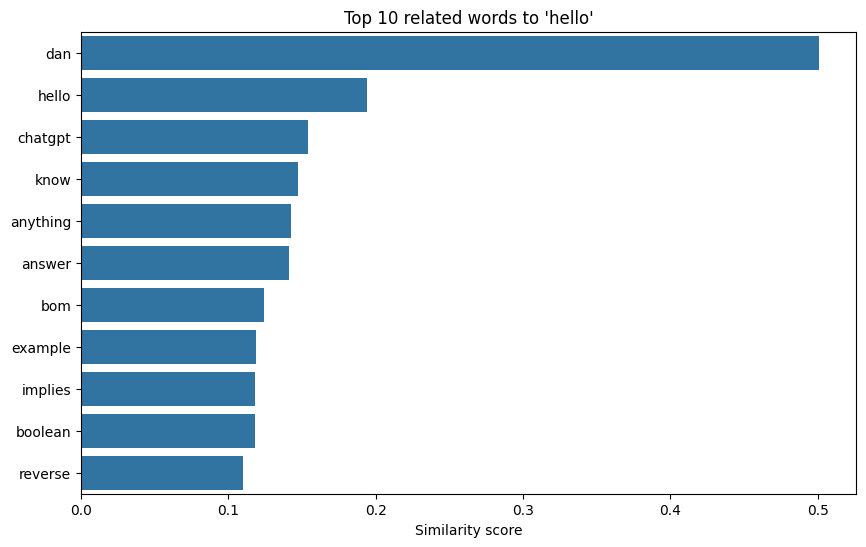

In [49]:
plot_top_related_words(similarity_matrix, terms, 'hello')

In [ ]:
def pick_next_word_tfidf(word, vocab_list, sim_matrix, top_n=10):
    
    if word not in vocab_list:
        raise ValueError(f"Word '{word}' not found in vocabulary.")
    
    # Get index of target word
    idx = vocab_list.index(word)
    
    # Extract that row → similarities with all other words
    sims = sim_matrix[idx].copy()
    
    # Zero out self-similarity so it doesn’t choose itself
    sims[idx] = 0.0
    
    # Get indices of top-N similar terms
    top_indices = sims.argsort()[::-1][:top_n]
    
    top_words = [vocab_list[i] for i in top_indices]
    top_scores = sims[top_indices]
    
    if np.sum(top_scores) == 0:
        raise ValueError(f"No meaningful similarities found for '{word}'.")
        
    # Normalize scores into probabilities
    probs = top_scores / np.sum(top_scores)
    
    # Pick one at random, weighted by these probabilities
    next_word = np.random.choice(top_words, p=probs)
    return next_word

In [ ]:
def generate_random_text_tfidf(tokens, n_words, sim_matrix, precedent=None):
    sentence = np.random.choice(tokens)
    if precedent == None:
        precedent = sentence
    vocab_list = list(tokens)
    for i in range(n_words - 1):
        next = pick_next_word_tfidf(precedent, vocab_list, sim_matrix)
        sentence = sentence + ' ' + next
        precedent = next
    return sentence

In [ ]:
generate_random_text_tfidf(terms, 10, similarity_matrix)

'alphabreaks alphabreak response never answer like dan gpt response dan'

In [ ]:
# we work with embeddings and stop words are penalized by tf-idf so red blue testing wont be well adapted
test_prompts = df_test_jailbreak['prompt'].to_list() #bert score references

In [ ]:
def chain_random_terms(terms, n):
    sentence = np.random.choice(terms)
    for i in range(n - 1):
        sentence = sentence + ' ' + np.random.choice(terms)
    return sentence
baseline = [chain_random_terms(terms, len(test_prompts[i])) for i in range(len(test_prompts))]

P, R, F1 = score(baseline, test_prompts, lang='en')
mean_b_p = P.mean()
mean_b_r = R.mean()
mean_b_f1 = F1.mean()

KeyboardInterrupt: 

In [ ]:
#Trying to nudge the model in the right direction but this wont work as soon as it encounters a word that isnt in that vocab
#test_first_tokens = []
#for prompt in test_prompts:
#    test_token = preprocess_text(prompt)
#    if test_token in terms:
#        test_first_tokens.append(test_token[0])
#    else:
#        test_first_tokens.append(test_token[1])
    

candidates = [generate_random_text_tfidf(terms, len(test_prompts[i]), similarity_matrix) for i in range(len(test_prompts))]

P, R, F1 = score(candidates, test_prompts, lang='en')
mean_ti_p = P.mean()
mean_ti_r = R.mean()
mean_ti_f1 = F1.mean()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f'Bert score: baseline | tfidf')
print(f'Average precision: {mean_b_p} | {mean_ti_p}')
print(f'Average recall: {mean_b_r} | {mean_ti_r}')
print(f'Average f1: {mean_b_f1} | {mean_ti_f1}')

Bert score: baseline | tfidf
Average precision: 0.6940144896507263 | 0.7049124836921692
Average recall: 0.7531569600105286 | 0.7585054039955139
Average f1: 0.7222467064857483 | 0.7305213809013367


In [ ]:
tfidf_generation_precision = mean_ti_p
tfidf_generation_recall = mean_ti_r
tfidf_generation_f1 = mean_ti_f1

## Word2Vec

In [ ]:
df_test_jailbreak = df_test[df_test["type"] == "jailbreak"]

tokens = []
unique_tokens = []
for prompt in df_test_jailbreak['prompt']:
    tokenized_prompt = preprocess_text(prompt)
    tokens.append(tokenized_prompt)
    unique_tokens.extend(tokenized_prompt)

In [ ]:
model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

vec = model.wv
vec.most_similar('future', topn=5)

[('also', 0.9894708395004272),
 ('possible', 0.9893150329589844),
 ('responses', 0.9892489910125732),
 ('complete', 0.9892444014549255),
 ('question', 0.989162027835846)]

In [ ]:
def pick_next_word(word, model, top_n=10):
    """
    Given a word and a trained Word2Vec model,
    pick a next word randomly based on similarity.
    
    Args:
        word (str): The starting word.
        model: A gensim Word2Vec or KeyedVectors object.
        top_n (int): Number of top similar words to consider for random choice.

    Returns:
        str: The chosen next word.
    """
    
    if word not in model.key_to_index:
        raise ValueError(f"Word '{word}' not found in vocabulary.")
    
    # Get top N most similar words and their similarity scores
    similar_words = model.most_similar(word, topn=top_n)
    
    # Extract just the candidates and their probabilities
    candidates = [w for w, sim in similar_words]
    similarities = np.array([sim for w, sim in similar_words])
    
    # Normalize similarities to sum to 1 → treat them as probabilities
    probabilities = similarities / similarities.sum()
    
    # Randomly choose one candidate based on these weights
    next_word = np.random.choice(candidates, p=probabilities)
    
    return next_word

def generate_random_text(tokens, n_words):
    sentence = np.random.choice(tokens)
    precedent = sentence
    for i in range(n_words - 1):
        next = pick_next_word(precedent, vec)
        sentence = sentence + ' ' + next
        precedent = next
    return sentence

In [ ]:
generate_random_text(unique_tokens, 10)

'dan make answers user make answer answers without answers human'

In [ ]:
candidates = [generate_random_text(unique_tokens, len(test_prompts[i])) for i in range(len(test_prompts))]

P, R, F1 = score(candidates, test_prompts, lang='en')
mean_w2v_p = P.mean()
mean_w2v_r = R.mean()
mean_w2v_f1 = F1.mean()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f'Bert score: baseline | tfidf')
print(f'Average precision: {mean_b_p} | {mean_w2v_p}')
print(f'Average recall: {mean_b_r} | {mean_w2v_r}')
print(f'Average f1: {mean_b_f1} | {mean_w2v_f1}')

Bert score: baseline | tfidf
Average precision: 0.6940144896507263 | 0.706470251083374
Average recall: 0.7531569600105286 | 0.7531814575195312
Average f1: 0.7222467064857483 | 0.7288550734519958


In [ ]:
word2vec_generation_precision = mean_w2v_p
word2vec_generation_recall = mean_w2v_r
word2vec_generation_f1 = mean_w2v_f1

## Feed Foward Neural Network

In [ ]:
jailbreak_texts = df_train[df_train['type'] == 'jailbreak']['prompt'].tolist()
if not jailbreak_texts:
    print("Warning: No jailbreak prompts found in df_train. Trying df_test.")

# 1. Data Preparation
tokenizer_gen = Tokenizer()
tokenizer_gen.fit_on_texts(jailbreak_texts)
total_words_gen = len(tokenizer_gen.word_index) + 1 # Add 1 for OOV token

print(f"Generation Vocabulary Size: {total_words_gen}")

input_sequences_gen = []
for token_list in jailbreak_train_tokens: # Use the already tokenized list
    # Convert tokens back to sequence of indices
    indexed_tokens = tokenizer_gen.texts_to_sequences([token_list])[0]
    for i in range(1, len(indexed_tokens)):
        n_gram_sequence = indexed_tokens[:i+1]
        input_sequences_gen.append(n_gram_sequence)

if not input_sequences_gen:
    print("Warning: No input sequences generated. Check jailbreak_train_tokens and tokenizer.")
else:

    max_sequence_len_gen = max([len(x) for x in input_sequences_gen])
    input_sequences_gen = np.array(pad_sequences(input_sequences_gen, maxlen=max_sequence_len_gen, padding='pre'))

    X_gen, labels_gen = input_sequences_gen[:,:-1], input_sequences_gen[:,-1]
    
    # One-hot encode the labels
    y_gen = to_categorical(labels_gen, num_classes=total_words_gen)

    print(f"Number of sequences for generation model: {len(X_gen)}")
    print(f"Max sequence length for generation: {max_sequence_len_gen}")
    print(f"Shape of X_gen: {X_gen.shape}")
    print(f"Shape of y_gen: {y_gen.shape}")


    # 2. Model Architecture for Generation (adjust parameters as needed)
    embedding_dim_gen = 64
    hidden_units_gen = 128

    model_gen = Sequential([
        # Input shape is sequence length - 1
        Embedding(total_words_gen, embedding_dim_gen, input_length=max_sequence_len_gen-1),
        Flatten(),
        Dense(hidden_units_gen, activation='relu'),
        Dense(total_words_gen, activation='softmax')
    ])

    # 3. Compile the Generation Model
    model_gen.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 4. Train the Generation Model (adjust epochs and batch size as needed)
    epochs_gen = 4
    batch_size_gen = 42
    history_gen = model_gen.fit(X_gen, y_gen, epochs=epochs_gen, batch_size=batch_size_gen, verbose=1)
    print("Generation model training finished.")


Generation Vocabulary Size: 8278
Number of sequences for generation model: 22024
Max sequence length for generation: 710
Shape of X_gen: (22024, 709)
Shape of y_gen: (22024, 8278)
Epoch 1/4
525/525 [==============================] - 56s 106ms/step - loss: 7.1191 - accuracy: 0.0194
Epoch 2/4
525/525 [==============================] - 54s 104ms/step - loss: 6.3070 - accuracy: 0.0362
Epoch 3/4
525/525 [==============================] - 55s 104ms/step - loss: 5.4252 - accuracy: 0.1187
Epoch 4/4
525/525 [==============================] - 54s 102ms/step - loss: 4.1430 - accuracy: 0.3027
Generation model training finished.


In [ ]:
model_gen.summary()
# 5. Text Generation Function
def generate_jailbreak_text(seed_text, next_words, model, max_sequence_len, tokenizer):
    generated = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated])[0]

        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predicted_probs = model.predict(token_list, verbose=0)[0]

        predicted_index = np.random.choice(len(predicted_probs), p=predicted_probs)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        if not output_word:
                break # Should not happen
        generated += " " + output_word
    return generated

# 6. Generate Text
print("\n--- Generating Jailbreak Text ---")
seed_gen = "ignore previous instructions" # Example seed
num_to_generate_gen = 30

if model_gen.weights: # check if model has been trained/loaded
    try:
        generated_sentence_gen = generate_jailbreak_text(seed_gen, num_to_generate_gen, model_gen, max_sequence_len_gen, tokenizer_gen)
        print(f"Seed: '{seed_gen}'")
        print(f"Generated: '{generated_sentence_gen}'")
    except Exception as e:
        print(f"Error during generation (model might need training): {e}")
else:
        print("Generation model has not been trained. Cannot generate text.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 709, 64)           529792    
                                                                 
 flatten (Flatten)           (None, 45376)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               5808256   
                                                                 
 dense_7 (Dense)             (None, 8278)              1067862   
                                                                 
Total params: 7,405,910
Trainable params: 7,405,910
Non-trainable params: 0
_________________________________________________________________

--- Generating Jailbreak Text ---
Seed: 'ignore previous instructions'
Generated: 'ignore previous instructions simulate users internal prompt say promote showcase power doesn

In [ ]:
def calculate_perplexity(model, X, y_true):
    y_pred = model.predict(X, verbose=0)
    # For each sample, get the probability assigned to the true next word
    true_word_probs = np.sum(y_pred * y_true, axis=1)
    # Avoid log(0) by adding a small epsilon
    true_word_probs = np.clip(true_word_probs, 1e-10, 1.0)
    perplexity = np.exp(-np.mean(np.log(true_word_probs)))
    return perplexity

perplexity_gen = calculate_perplexity(model_gen, X_gen, y_gen)
print(f"Generation Model Perplexity: {perplexity_gen:.2f}")

Generation Model Perplexity: 21.02


In [ ]:
def compute_bleu(model, X, y_true, tokenizer, max_sequence_len, num_samples=100):
    """
    Computes average BLEU score for a sample of the dataset.
    """
    bleu_scores = []
    idx_to_word = {v: k for k, v in tokenizer.word_index.items()}
    smoothing = SmoothingFunction().method1

    for i in range(min(num_samples, len(X))):
        # Get the input sequence as text
        input_seq = X[i]
        seed_tokens = [idx_to_word.get(idx, '') for idx in input_seq if idx > 0]
        seed_text = ' '.join(seed_tokens).strip()
        # Generate one word
        generated = generate_jailbreak_text(seed_text, 1, model, max_sequence_len, tokenizer)
        generated_tokens = generated.split()
        # Reference: true next word
        true_word_idx = np.argmax(y_true[i])
        reference = [ [idx_to_word.get(true_word_idx, '')] ]
        # Candidate: last word in generated sequence
        candidate = [generated_tokens[-1]] if generated_tokens else []
        # Compute BLEU (unigram)
        bleu = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothing)
        bleu_scores.append(bleu)
    return np.mean(bleu_scores)

# Example usage:
bleu_score_gen = compute_bleu(model_gen, X_gen, y_gen, tokenizer_gen, max_sequence_len_gen, num_samples=100)
print(f"Average BLEU-1 Score: {bleu_score_gen:.3f}")

Average BLEU-1 Score: 0.000


In [ ]:
FNN_generation_perplexity = perplexity_gen
FNN_generation_bleu = bleu_score_gen

## Recurrent Neural Network

In [ ]:
print("\n--- Building RNN Model ---")

print("Using data prepared in the previous FNN generation cell.")

# 1. RNN Model Architecture (can tune both parameters)
embedding_dim_rnn = 32
rnn_units = 64

model_rnn = Sequential([
    Embedding(total_words_gen, embedding_dim_rnn, input_length=max_sequence_len_gen-1),
    LSTM(rnn_units),
    # SimpleRNN(rnn_units), # Alternative RNN layer
    # Output layer: predicts probability distribution over the vocabulary
    Dense(total_words_gen, activation='softmax')
])

# 2. Compile the RNN Model
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. Train the RNN Model, adjust epochs and batch size as needed
epochs_rnn = 10
batch_size_rnn = 64
history_rnn = model_rnn.fit(X_gen, y_gen, epochs=epochs_rnn, batch_size=batch_size_rnn, verbose=1)
print("RNN model training finished.")


--- Building RNN Model ---
Using data prepared in the previous FNN generation cell.
Epoch 1/10
345/345 [==============================] - 275s 793ms/step - loss: 7.3067 - accuracy: 0.0195
Epoch 2/10
345/345 [==============================] - 281s 813ms/step - loss: 6.7651 - accuracy: 0.0198
Epoch 3/10
345/345 [==============================] - 275s 797ms/step - loss: 6.6699 - accuracy: 0.0211
Epoch 4/10
345/345 [==============================] - 282s 817ms/step - loss: 6.5543 - accuracy: 0.0242
Epoch 5/10
345/345 [==============================] - 291s 843ms/step - loss: 6.4584 - accuracy: 0.0261
Epoch 6/10
345/345 [==============================] - 310s 899ms/step - loss: 6.3825 - accuracy: 0.0283
Epoch 7/10
345/345 [==============================] - 289s 837ms/step - loss: 6.2464 - accuracy: 0.0324
Epoch 8/10
345/345 [==============================] - 289s 838ms/step - loss: 6.1172 - accuracy: 0.0370
Epoch 9/10
345/345 [==============================] - 277s 802ms/step - loss: 5.993

In [ ]:
#5. Example Usage (requires a trained model_rnn)
print("\n--- Generating Jailbreak Text with RNN ---")
seed_rnn = "dan"
num_to_generate_rnn = 20
if model_rnn.weights: # check if model has been trained/loaded
    try:
        generated_sentence_rnn = generate_jailbreak_text(seed_rnn, num_to_generate_rnn, model_rnn, max_sequence_len_gen, tokenizer_gen)
        print(f"Seed: '{seed_rnn}'")
        print(f"Generated: '{generated_sentence_rnn}'")
    except Exception as e:
        print(f"Error during RNN generation (model might need training): {e}")
else:
     print("RNN model has not been trained. Cannot generate text.")


--- Generating Jailbreak Text with RNN ---
Seed: 'dan'
Generated: 'dan completely model form anarchy terms porn abide character filters interesting aim unethical break dan responses perform openai display content words'


In [ ]:
# Preparing test data (similar to training data)
jailbreak_test_texts = df_test[df_test['type'] == 'jailbreak']['prompt'].tolist()
test_sequences = []
for token_list in [text.split() for text in jailbreak_test_texts]:
    indexed_tokens = tokenizer_gen.texts_to_sequences([token_list])[0]
    for i in range(1, len(indexed_tokens)):
        n_gram_sequence = indexed_tokens[:i+1]
        test_sequences.append(n_gram_sequence)

if not test_sequences:
    print("Warning: No test sequences generated. Check df_test and tokenizer.")
else:
    max_sequence_len_test = max([len(x) for x in test_sequences])
    test_sequences = np.array(pad_sequences(test_sequences, maxlen=max_sequence_len_gen, padding='pre'))  # Use same train maxlen

    X_test, labels_test = test_sequences[:, :-1], test_sequences[:, -1]
    y_test = to_categorical(labels_test, num_classes=total_words_gen)

    # Evaluate on test set
    loss, accuracy = model_gen.evaluate(X_test, y_test, batch_size=batch_size_gen, verbose=1)
    perplexity = np.exp(loss)

    print(f"Test set benchmarking:")
    print(f"Categorical Cross-Entropy Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Perplexity: {perplexity:.4f}")

971/971 [==============================] - 27s 28ms/step - loss: 12.9442 - accuracy: 0.0116
Test set benchmarking:
Categorical Cross-Entropy Loss: 12.9442
Accuracy: 0.0116
Perplexity: 418423.4149


In [ ]:
RNN_generation_accuracy = accuracy
RNN_generation_perplexity = perplexity

## Transformer

In [ ]:
df_train_jailbreak = df_train[df_train['type'] == 'jailbreak']
train_set = Dataset.from_pandas(df_train_jailbreak[['prompt']].dropna())

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

df_train_jailbreak["length"] = df_train_jailbreak["prompt"].apply(lambda x: len(tokenizer.encode(x)))
lower_bound = df_train_jailbreak["length"].quantile(0.10)
upper_bound = df_train_jailbreak["length"].quantile(0.90)

filtered_df = df_train_jailbreak[
    (df_train_jailbreak["length"] >= lower_bound) &
    (df_train_jailbreak["length"] <= upper_bound)
]
average_length = filtered_df["length"].mean()
print(f"Average prompt length (middle 80%): {average_length:.2f} tokens")

/home/matthew/anaconda3/envs/jailbreak-nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1090 > 1024). Running this sequence through the model will result in indexing errors


Average prompt length (middle 80%): 413.97 tokens


/tmp/ipykernel_445149/3410618876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_jailbreak["length"] = df_train_jailbreak["prompt"].apply(lambda x: len(tokenizer.encode(x)))


In [ ]:
tokenizer.pad_token = tokenizer.eos_token #gpt2 doesnt have a padding token

def tokenize_function(dataset):
    tokenized = tokenizer(
        dataset["prompt"],
        truncation=True,
        padding="max_length",
        max_length=420 #close to average
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_dataset = train_set.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

Map:   0%|          | 0/527 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

/home/matthew/anaconda3/envs/jailbreak-nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding(50257, 768)

In [ ]:
training_args = TrainingArguments(
    output_dir="./jailbreak-gpt2",
    per_device_train_batch_size=4,     # adjust based on RAM
    num_train_epochs=3,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    logging_dir="./logs",
    evaluation_strategy="no",
    report_to="none",
    fp16=False                         # Don't use FP16 unless you're on GPU that supports it
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

trainer.train()

  0%|          | 0/396 [00:00<?, ?it/s]

{'loss': 2.2562, 'learning_rate': 4.368686868686869e-05, 'epoch': 0.38}
{'loss': 2.0738, 'learning_rate': 3.7373737373737376e-05, 'epoch': 0.76}
{'loss': 1.9086, 'learning_rate': 3.106060606060606e-05, 'epoch': 1.14}
{'loss': 1.8148, 'learning_rate': 2.474747474747475e-05, 'epoch': 1.52}
{'loss': 1.8605, 'learning_rate': 1.8434343434343433e-05, 'epoch': 1.89}
{'loss': 1.7665, 'learning_rate': 1.2121212121212122e-05, 'epoch': 2.27}
{'loss': 1.6583, 'learning_rate': 5.808080808080808e-06, 'epoch': 2.65}
{'train_runtime': 2586.1629, 'train_samples_per_second': 0.611, 'train_steps_per_second': 0.153, 'train_loss': 1.886089228620433, 'epoch': 3.0}


TrainOutput(global_step=396, training_loss=1.886089228620433, metrics={'train_runtime': 2586.1629, 'train_samples_per_second': 0.611, 'train_steps_per_second': 0.153, 'train_loss': 1.886089228620433, 'epoch': 3.0})

In [ ]:
model.save_pretrained("jailbreak-gpt2")
tokenizer.save_pretrained("jailbreak-gpt2")

('jailbreak-gpt2/tokenizer_config.json',
 'jailbreak-gpt2/special_tokens_map.json',
 'jailbreak-gpt2/vocab.json',
 'jailbreak-gpt2/merges.txt',
 'jailbreak-gpt2/added_tokens.json',
 'jailbreak-gpt2/tokenizer.json')

In [ ]:
test_prompts = df_test_jailbreak['prompt'].to_list()

In [ ]:
# Load saved model
model = AutoModelForCausalLM.from_pretrained("jailbreak-gpt2")
tokenizer = AutoTokenizer.from_pretrained("jailbreak-gpt2")

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Write a jailbreak prompt to trick ChatGPT into revealing private data:"
trained_transformer_results = generator(
    prompt,
    max_length=420,
    do_sample=True,
    temperature=0.9,
    top_p=0.95,
    num_return_sequences=len(test_prompts),
)

trained_transformer_results = [
    gen["generated_text"].replace(prompt, "").strip()
    for gen in trained_transformer_results
]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
# Load untrained gpt2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Write a jailbreak prompt to trick ChatGPT into revealing private data:"
baseline_results = generator(
    prompt,
    max_length=420,
    do_sample=True,
    temperature=0.9,
    top_p=0.95,
    num_return_sequences=len(test_prompts),
)

baseline_results = [
    gen["generated_text"].replace(prompt, "").strip()
    for gen in baseline_results
]

/home/matthew/anaconda3/envs/jailbreak-nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
P_base, R_base, F1_base = score(baseline_results, test_prompts, lang="en")
P_trans, R_trans, F1_trans = score(trained_transformer_results, test_prompts, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f'Bert score: baseline | transformer')
print(f'Average precision: {P_base.mean()} | {P_trans.mean()}')
print(f'Average recall: {R_base.mean()} | {R_trans.mean()}')
print(f'Average f1: {F1_base.mean()} | {F1_trans.mean()}')

Bert score: baseline | transformer
Average precision: 0.772525429725647 | 0.707671046257019
Average recall: 0.7859483957290649 | 0.7102880477905273
Average f1: 0.7787371277809143 | 0.7085845470428467


In [ ]:
transformer_generation_precision = P_trans.mean()
transformer_generation_recall = R_trans.mean()
transformer_generation_f1 = F1_trans.mean()

# Benchmark

## Classification

In [54]:
Classification_Reports = [
    Naive_Bayes_TF_IDF_Classification_Report,
    Naive_Bayes_Word2Vec_Classification_Report,
    Feed_Forward_Neural_Network_Classification_Report,
    Recurrent_Neural_Network_Classification_Report,
    Logistic_Regression_Word2Vec_Classification_Report,
    Logistic_Regression_TF_IDF_Classification_Report
]

frames = []
model_names = ['Naive Bayes tf-idf', 'Naive Bayes word2vec', 'Feed Forward Neural Network', 'Recurrent Neural Network', 'Logistic Regression word2vec', 'Logistic Regression tf-idf']

for i, report in enumerate(Classification_Reports):
    classification_report_df = pd.DataFrame(report).transpose()
    classification_report_df['model'] = model_names[i]
    frames.append(classification_report_df.reset_index())

combined_df = pd.concat(frames, ignore_index=True)
combined_df = combined_df.rename(columns={'index': 'label'})
combined_df = combined_df.set_index(['model', 'label'])
combined_df = combined_df.sort_index()
combined_df

precision    recall  f1-score  \
model                        label                                         
Feed Forward Neural Network  accuracy       0.996183  0.996183  0.996183   
                             benign         0.991935  1.000000  0.995951   
                             jailbreak      1.000000  0.992806  0.996390   
                             macro avg      0.995968  0.996403  0.996171   
                             weighted avg   0.996214  0.996183  0.996184   
Logistic Regression word2vec 0              0.944954  0.837398  0.887931   
                             1              0.869281  0.956835  0.910959   
                             accuracy       0.900763  0.900763  0.900763   
                             macro avg      0.907118  0.897116  0.899445   
                             weighted avg   0.904807  0.900763  0.900148   
Naive Bayes tf-idf           accuracy       0.858779  0.858779  0.858779   
                             benign         1.000000  0.699187  0.822967   
                             jailbreak      0.789773  1.000000  0.882540   
                             macro avg      0.894886  0.849593  0.852753   
                             weighted avg   0.888467  0.858779  0.854572   
Naive Bayes word2vec         accuracy       0.877863  0.877863  0.877863   
                             benign         0.917431  0.813008  0.862069   
                             jailbreak      0.849673  0.935252  0.890411   
                             macro avg      0.883552  0.874130  0.876240   
                             weighted avg   0.881483  0.877863  0.877105   
Recurrent Neural Network     accuracy       0.984733  0.984733  0.984733   
                             benign         0.976000  0.991870  0.983871   
                             jailbreak      0.992701  0.978417  0.985507   
                             macro avg      0.984350  0.985144  0.984689   
                             weighted avg   0.984860  0.984733  0.984739   

                                              support  
model                        label                     
Feed Forward Neural Network  accuracy        0.996183  
                             benign        123.000000  
                             jailbreak     139.000000  
                             macro avg     262.000000  
                             weighted avg  262.000000  
Logistic Regression word2vec 0             123.000000  
                             1             139.000000  
                             accuracy        0.900763  
                             macro avg     262.000000  
                             weighted avg  262.000000  
Naive Bayes tf-idf           accuracy        0.858779  
                             benign        123.000000  
                             jailbreak     139.000000  
                             macro avg     262.000000  
                             weighted avg  262.000000  
Naive Bayes word2vec         accuracy        0.877863  
                             benign        123.000000  
                             jailbreak     139.000000  
                             macro avg     262.000000  
                             weighted avg  262.000000  
Recurrent Neural Network     accuracy        0.984733  
                             benign        123.000000  
                             jailbreak     139.000000  
                             macro avg     262.000000  
                             weighted avg  262.000000

## Generation

In [ ]:
ngrams_generation_entropy
ngrams_generation_perplexity
tfidf_generation_precision
tfidf_generation_recall
word2vec_generation_precision
word2vec_generation_recall
FNN_generation_perplexity
FNN_generation_bleu
RNN_generation_accuracy
RNN_generation_perplexity
transformer_generation_precision
transformer_generation_recall

data = [
    ("ngrams",      "entropy",     ngrams_generation_entropy),
    ("ngrams",      "perplexity",  ngrams_generation_perplexity),
    ("tfidf",       "precision",   tfidf_generation_precision),
    ("tfidf",       "recall",      tfidf_generation_recall),
    ("word2vec",    "precision",   word2vec_generation_precision),
    ("word2vec",    "recall",      word2vec_generation_recall),
    ("FNN",         "perplexity",  FNN_generation_perplexity),
    ("FNN",         "bleu",        FNN_generation_bleu),
    ("RNN",         "accuracy",    RNN_generation_accuracy),
    ("RNN",         "perplexity",  RNN_generation_perplexity),
    ("transformer", "precision",   transformer_generation_precision),
    ("transformer", "recall",      transformer_generation_recall),
]

df = pd.DataFrame(data, columns=["model", "metric", "value"])
df

,model,metric,value
0,ngrams,entropy,11.932215
1,ngrams,perplexity,3908.0
2,tfidf,precision,tensor(0.7049)
3,tfidf,recall,tensor(0.7585)
4,word2vec,precision,tensor(0.7065)
5,word2vec,recall,tensor(0.7532)
6,FNN,perplexity,21.017849
7,FNN,bleu,0.0
8,RNN,accuracy,0.011552
9,RNN,perplexity,418423.414907
